In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
# Load the dataset
data = pd.read_csv('/kaggle/input/diabetes/diabetic_data.csv')

In [40]:
# Initial data exploration
print(data.head())
print(data.describe())
print(data.info())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [41]:
# Identifying numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Handling missing values only in numeric columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


In [42]:
# Identifying categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Handling missing values in categorical columns by replacing them with the mode
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])


In [44]:
print(data.columns)


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [69]:
# Replace 'ColumnName' with the actual name of the column you're trying to analyze
print(data['readmitted'].unique())


['NO' '>30' '<30']


In [73]:
# Converting 'NO' and 'YES' to 0 and 1 in the column. Adjust accordingly.
data['readmitted'] = data['readmitted'].replace({'NO': 0, 'YES': 1})
data['readmitted'] = data['readmitted'].replace({'>30': 0, '<30': 1})


/tmp/ipykernel_33/4121032910.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['readmitted'] = data['readmitted'].replace({'>30': 0, '<30': 1})


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


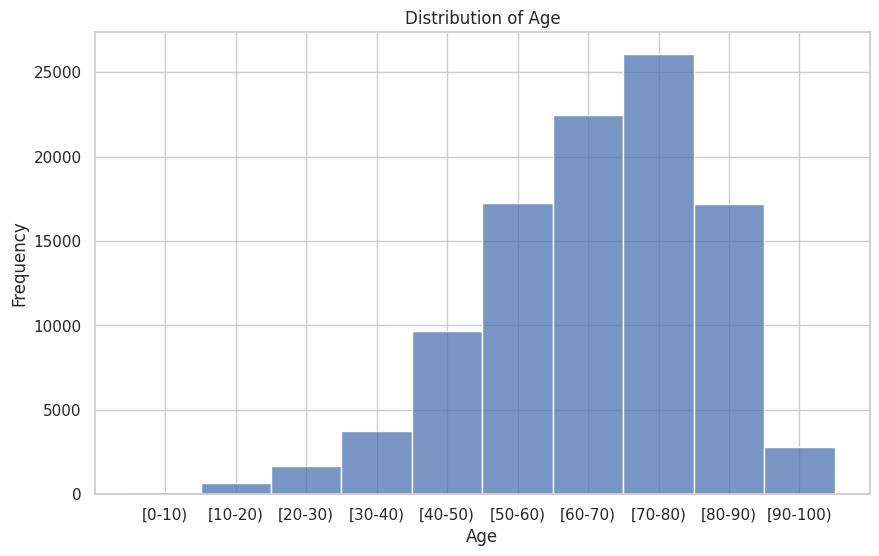

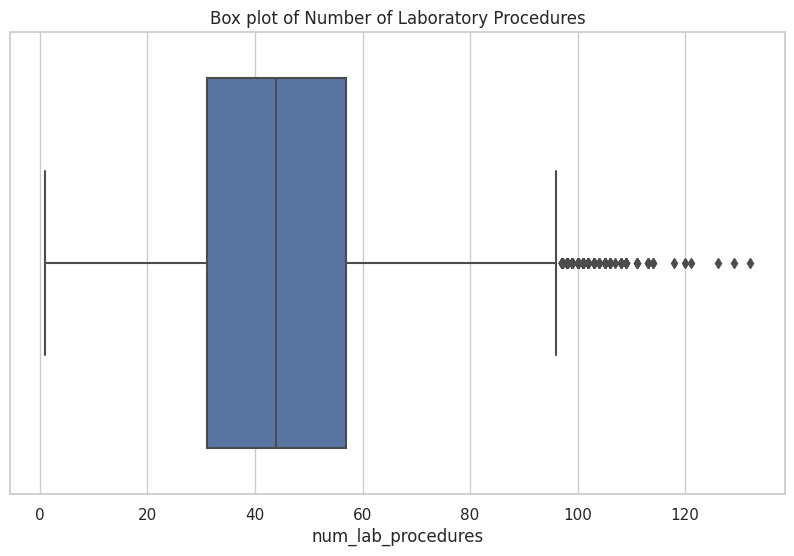

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# Visualizing the distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=False, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Checking for outliers using box plots for numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_lab_procedures', data=data)
plt.title('Box plot of Number of Laboratory Procedures')
plt.show()


In [78]:
# Investigate outliers further
high_procedures = data[data['num_lab_procedures'] > 100]  # Adjust the threshold based on your analysis
print(high_procedures.describe())


       encounter_id   patient_nbr  admission_type_id  \
count  6.400000e+01  6.400000e+01          64.000000   
mean   1.517750e+08  6.109152e+07           3.125000   
std    1.034492e+08  3.717885e+07           2.497618   
min    3.331848e+06  3.475080e+05           1.000000   
25%    7.157693e+07  2.729904e+07           1.000000   
50%    1.507015e+08  6.477070e+07           1.000000   
75%    1.984722e+08  9.354177e+07           6.000000   
max    4.414629e+08  1.414851e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count                 64.000000            64.000000         64.000000   
mean                   5.109375             8.703125          9.250000   
std                    5.874662             4.939892          3.217018   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             7.000000          7.000000   
50%                    3.000000             7.00000

In [79]:
# Correlation of Num_Lab_Procedures with Readmission
correlation_with_readmission = data[['num_lab_procedures', 'readmitted']].corr()
print(correlation_with_readmission)


                    num_lab_procedures  readmitted
num_lab_procedures            1.000000    0.020364
readmitted                    0.020364    1.000000


In [81]:
# Convert 'age' and 'num_lab_procedures' to numeric, coercing errors to NaN
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['num_lab_procedures'] = pd.to_numeric(data['num_lab_procedures'], errors='coerce')

# Check for any remaining non-numeric entries
print(data[data['age'].isna()])
print(data[data['num_lab_procedures'].isna()])


        encounter_id  patient_nbr             race  gender  age weight  \
0            2278392      8222157        Caucasian  Female  NaN      ?   
1             149190     55629189        Caucasian  Female  NaN      ?   
2              64410     86047875  AfricanAmerican  Female  NaN      ?   
3             500364     82442376        Caucasian    Male  NaN      ?   
4              16680     42519267        Caucasian    Male  NaN      ?   
...              ...          ...              ...     ...  ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  NaN      ?   
101762     443847782     74694222  AfricanAmerican  Female  NaN      ?   
101763     443854148     41088789        Caucasian    Male  NaN      ?   
101764     443857166     31693671        Caucasian  Female  NaN      ?   
101765     443867222    175429310        Caucasian    Male  NaN      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6          

In [82]:
# Example: Filling NaNs with the median of the column
data['age'].fillna(data['age'].median(), inplace=True)
data['num_lab_procedures'].fillna(data['num_lab_procedures'].median(), inplace=True)


/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_33/1241237203.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
/tmp/ipykernel_33/1241237203.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will n

In [83]:
# Recreate the 'High_Lab_Procedures' and 'Age_Group' features
data['High_Lab_Procedures'] = (data['num_lab_procedures'] > 100).astype(int)
data['Age_Group'] = pd.cut(data['age'], bins=[0, 30, 60, 90, 120], labels=['0-30', '30-60', '60-90', '90+'])
